In [1]:
import sys
sys.path.append('..')
import torch
import os
import torch.nn as nn
import torchvision
from torch.utils.data.dataloader import DataLoader
from torch.utils.data.dataset import Dataset
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import random
from models.CycleGAN import *
from datasets.UnalignedDataset import UnalignedDataset
from utils.utils import ImageBuffer, set_requires_grad, tensor_to_image, save_cyclegan_model, get_activation, get_norm_module

os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [2]:
class ContentEncoder(nn.Module):
    
    def __init__(self, num_channels, num_blocks, content_dim):
        super(ContentEncoder, self).__init__()
        
        self.conv1 = ConvNormRelu(in_channels=num_channels, out_channels=64,
                                  kernel_size=7, padding=(3, "zeros"), leaky=False, norm='instance')
        self.conv2 = ConvNormRelu(in_channels=64, out_channels=128, 
                                  kernel_size=4, padding=(1, "zeros"), stride=2, leaky=False, norm='instance')
        self.conv3 = ConvNormRelu(in_channels=128, out_channels=256, 
                                 kernel_size=4, padding=(1, "zeros"), stride=2, leaky=False, norm='instance')
        self.blocks = nn.ModuleList()
        for _ in range(num_blocks):
            self.blocks.append(ResBlock(in_planes=content_dim, kernel_size=3, padding=(1, "reflection"), norm="instance"))
    
    def forward(self, inputs):
        out = self.conv1(inputs)
        out = self.conv2(out)
        out = self.conv3(out)
        for block in self.blocks:
            out = block(out)
        return out

In [3]:
class StyleEncoder(nn.Module):
    
    def __init__(self, num_channels, style_dims):
        super(StyleEncoder, self).__init__()
        
        self.conv1 = ConvNormRelu(in_channels=num_channels, out_channels=64,
                                  kernel_size=7, padding=(3, "zeros"), leaky=False, norm='instance')
        
        self.convs = nn.ModuleList()
        dims = 64
        prev_dims = 0
        n_convs = 4
        
        for _ in range(n_convs):
            prev_dims = dims
            dims = min(dims * 2, 256)
            
            self.convs.append(ConvNormRelu(in_channels=prev_dims, out_channels=dims, 
                                  kernel_size=4, padding=(1, "zeros"), stride=2, leaky=False, norm='instance'))
        
        self.conv_fc = nn.Conv2d(dims, style_dims, kernel_size=1, stride=1, padding=0)  
            
    def forward(self, inputs):
        out = self.conv1(inputs)
        for conv in self.convs:
            out = conv(out)
            
        #Fastest version of Global Average Pooling
        out = torch.mean(out.view(out.size(0), out.size(1), -1), dim=2)
        out = out.view(out.size(0), out.size(1), 1, 1)
        out = self.conv_fc(out)
        return out.view(out.size(0), out.size(1))

In [4]:
#Nvidia implementation
class AdaptiveInstanceNorm2d(nn.Module):
    def __init__(self, num_features, eps=1e-5, momentum=0.1):
        super(AdaptiveInstanceNorm2d, self).__init__()
        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum
        # weight and bias are dynamically assigned
        self.weight = None
        self.bias = None
        # just dummy buffers, not used
        self.register_buffer('running_mean', torch.zeros(num_features))
        self.register_buffer('running_var', torch.ones(num_features))

    def forward(self, x):
        assert self.weight is not None and self.bias is not None, "Please assign weight and bias before calling AdaIN!"
        b, c = x.size(0), x.size(1)
        running_mean = self.running_mean.repeat(b)
        running_var = self.running_var.repeat(b)

        # Apply instance norm
        x_reshaped = x.contiguous().view(1, b * c, *x.size()[2:])

        out = F.batch_norm(
            x_reshaped, running_mean, running_var, self.weight, self.bias,
            True, self.momentum, self.eps)

        return out.view(b, c, *x.size()[2:])

    def __repr__(self):
        return self.__class__.__name__ + '(' + str(self.num_features) + ')'

In [5]:
class Decoder(nn.Module):
    
    def __init__(self, in_channels):
        super(Decoder, self).__init__()
        
        self.blocks = nn.ModuleList()
        n_blocks = 4
        for _ in range(n_blocks):
            self.blocks.append(ResBlock(in_planes=in_channels, kernel_size=3,
                                        padding=(1, "reflection"), norm="adain"))
        n_blocks = 2
        self.upsample_blocks = nn.ModuleList()
        prev_dims = 0
        dims = 256
        for _ in range(n_blocks):
            prev_dims = dims
            dims = dims // 2
            self.upsample_blocks.append(nn.Upsample(scale_factor=2))
            self.upsample_blocks.append(ConvNormRelu(in_channels=prev_dims, out_channels=dims,
                                                     kernel_size=5, padding=(2, "reflection"), stride=1, norm="ln"))
            
        self.last_layer = ConvNormRelu(in_channels=dims, out_channels=3, kernel_size=7,
                                      padding=(3, "reflection"), stride=1, norm=None)
        
    def forward(self, inputs):
        out = inputs
        for block in self.blocks:
            out = block(out)
        for block in self.upsample_blocks:
            out = block(out)
        return F.tanh(self.last_layer(out))

In [6]:
class LinearNormAct(nn.Module):
    
    def __init__(self, in_channels, out_channels, norm='batch', activation="relu"):
        super(LinearNormAct, self).__init__()
        
        self.fc = nn.Linear(in_channels, out_channels)
        self.norm = get_norm_module(norm)(out_channels)
        self.activation = get_activation(activation)
    
    def forward(self, inputs):
        out = self.fc(inputs)
        out = self.norm(out)
        if self.activation:
            return self.activation(out)
        else:
            return out

In [7]:
class MLP(nn.Module):
    
    def __init__(self, in_channels, out_channels, hidden_dim, num_blocks):
        super(MLP, self).__init__()
        
        self.fc1 = LinearNormAct(in_channels=in_channels, out_channels=hidden_dim, norm="none")
        
        self.blocks = nn.ModuleList()
        for _ in range(num_blocks - 2):
            self.blocks.append(LinearNormAct(in_channels=hidden_dim, out_channels=hidden_dim, norm="none"))
        
        self.last_fc = LinearNormAct(in_channels=hidden_dim, out_channels=out_channels, norm="none", activation="none")
        
    def forward(self, inputs):
        
        out = self.fc1(inputs)
        for block in self.blocks:
            out = block(out)
        return self.last_fc(out)
    

In [8]:
class MUnitAutoencoder(nn.Module):
    
    def __init__(self, in_channels, mlp_hidden_dim, mlp_num_blocks, enc_style_dims, enc_cont_num_blocks, enc_cont_dim=256):
        super(MUnitAutoencoder, self).__init__()
        
        
        self.enc_cont = ContentEncoder(num_channels=in_channels, num_blocks=enc_cont_num_blocks, content_dim=enc_cont_dim)
        self.enc_style = StyleEncoder(num_channels=in_channels, style_dims=enc_style_dims)
        
        self.decoder = Decoder(in_channels=enc_cont_dim)
        self.mlp = MLP(in_channels=enc_style_dims, out_channels=self.get_num_adain_params(self.decoder),
                       hidden_dim=mlp_hidden_dim, num_blocks=mlp_num_blocks)
        
    
    
    
    def encode(self, inputs):
        enc_cont = self.enc_cont(inputs)
        enc_style = self.enc_style(inputs)
        return enc_cont, enc_style
    
    def decode(self, enc_cont, enc_style):
        features = self.mlp(enc_style)
        self.assign_adain_params(features, self.decoder)
        return self.decoder(enc_cont)
    
    def forward(self, inputs):
        enc_cont, enc_style = self.encode(inputs)
        rec_inputs = self.decode(enc_cont, enc_style)
        return rec_inputs
    
    #Nvidia
    def assign_adain_params(self, adain_params, model):
        # assign the adain_params to the AdaIN layers in model
        for m in model.modules():
            if m.__class__.__name__ == "AdaptiveInstanceNorm2d":
                mean = adain_params[:, :m.num_features]
                std = adain_params[:, m.num_features:2*m.num_features]
                m.bias = mean.contiguous().view(-1)
                m.weight = std.contiguous().view(-1)
                if adain_params.size(1) > 2*m.num_features:
                    adain_params = adain_params[:, 2*m.num_features:]
    
    #Nvidia
    def get_num_adain_params(self, model):
        # return the number of AdaIN parameters needed by the model
        num_adain_params = 0
        for m in model.modules():
            if m.__class__.__name__ == "AdaptiveInstanceNorm2d":
                num_adain_params += 2*m.num_features
        return num_adain_params

In [9]:
class MSDiscriminator(nn.Module):
    
    def __init__(self, in_channels, num_scales):
        super(MSDiscriminator, self).__init__()
        
        self.discrs = nn.ModuleList()
        self.in_channels = in_channels
        self.num_scales = num_scales
        for _ in range(self.num_scales):
            self.discrs.append(self.create_discr(self.in_channels))
        
        self.downsample = nn.AvgPool2d(kernel_size=3, stride=2, padding=1, count_include_pad=False)
        
        
    
    def create_discr(self, in_channels):
        prev_dims = 0
        dims = 64
        self.discr = []
        n_blocks = 3
        
        self.discr += [ConvNormRelu(in_channels=in_channels, out_channels=dims, 
                                  kernel_size=4, padding=(1, "zeros"), stride=2, leaky=True, norm='none')]
        
        for _ in range(n_blocks):
            prev_dims = dims
            dims = dims * 2
            self.discr += [ConvNormRelu(in_channels=prev_dims, out_channels=dims, 
                                  kernel_size=4, padding=(1, "zeros"), stride=2, leaky=True, norm='instance')]
        
        self.discr += [nn.Conv2d(dims, out_channels=1, kernel_size=1, padding=0)]
        return nn.Sequential(*self.discr)
        
    
    def forward(self, inputs):
        outputs = []
        for discr in self.discrs:
            outputs.append(discr(inputs))
            inputs = self.downsample(inputs)
        return outputs
    
    def discr_loss(self, real, fake):
        outputs_real = self.forward(real)
        outputs_fake = self.forward(fake.detach())
        loss_fake = 0
        loss_real = 0
        for i in range(self.num_scales):
            loss_fake += calc_mse_loss(outputs_fake[i], 0)
            loss_real += calc_mse_loss(outputs_real[i], 1)
        
        loss = (loss_fake + loss_real) * (1/2)
        
        return loss
    
    
    def gen_loss(self, fake):
        loss = 0
        outputs_fake = self.forward(fake)
        for i in range(self.num_scales):
            loss += calc_mse_loss(outputs_fake[i], 1) 
        return loss

In [10]:
class MUnit(nn.Module):
    
    
    def __init__(self, in_channels, mlp_hidden_dim, mlp_num_blocks, d_num_scales, enc_style_dims,
                 enc_cont_num_blocks, enc_cont_dim=256):
        super(MUnit, self).__init__()
        
        
        self.G1 = MUnitAutoencoder(in_channels=in_channels, mlp_hidden_dim=mlp_hidden_dim, mlp_num_blocks=mlp_num_blocks,
                                   enc_style_dims=enc_style_dims, enc_cont_num_blocks=enc_cont_num_blocks,
                                   enc_cont_dim=enc_cont_dim)
        
        self.G2 = MUnitAutoencoder(in_channels=in_channels, mlp_hidden_dim=mlp_hidden_dim, mlp_num_blocks=mlp_num_blocks,
                                   enc_style_dims=enc_style_dims, enc_cont_num_blocks=enc_cont_num_blocks,
                                   enc_cont_dim=enc_cont_dim)
        
        self.D1 = MSDiscriminator(in_channels, num_scales=d_num_scales)
        
        self.D2 = MSDiscriminator(in_channels, num_scales=d_num_scales)
        
    
    
    def forward(self, domain_A, domain_B):
        
        cont_A, style_A = self.G1.encode(domain_A)
        cont_B, style_B = self.G2.encode(domain_B)
        
        fake_style_B = torch.randn(*style_B.shape).cuda()
        fake_style_A = torch.randn(*style_A.shape).cuda()
        
        fake_A = self.G1.decode(cont_B, fake_style_B)
        fake_B = self.G2.decode(cont_A, fake_style_A)
        
        return cont_A, style_A, cont_B, style_B, fake_style_A, fake_A, fake_style_B, fake_B
        
    def backward_Gs(self, domain_A, domain_B, cont_A, style_A, cont_B, style_B, fake_style_A, fake_A, fake_style_B, fake_B):

        #cont_A, style_A = G1.encode(inputs)
        #Reconstructed images
        rec_img_A = self.G1.decode(cont_A, style_A)
        rec_img_B = self.G2.decode(cont_B, style_B)
        
        #fake_style = torch.randn(*style.shape)
        
        #Reconstructed latent contents and styles
        rec_cont_A, rec_fake_style_B = self.G2.encode(fake_B)
        rec_cont_B, rec_fake_style_A = self.G1.encode(fake_A)
        
        #Loss of reconstructed images
        img_rec_loss_A = F.l1_loss(rec_img_A, domain_A)
        img_rec_loss_B = F.l1_loss(rec_img_B, domain_B)
        #print("img_rec_loss: ", img_rec_loss_A, img_rec_loss_B)
        
        #Loss of reconstructed latent content and styles
        #cont_loss_A = F.l1_loss(rec_cont_A, cont_A)
        cont_loss_A = torch.mean(torch.abs(rec_cont_A - cont_A))
        #cont_loss_B = F.l1_loss(rec_cont_B, cont_B)
        cont_loss_B = torch.mean(torch.abs(rec_cont_B - cont_B))
        #print("cont_loss: ", cont_loss_A, cont_loss_B)
        
        style_loss_A = F.l1_loss(rec_fake_style_A, fake_style_A)
        style_loss_B = F.l1_loss(rec_fake_style_B, fake_style_B)
        #print("style_loss: ", style_loss_A, style_loss_B)
        
        #Adversarial loss of generated pics
        adv_loss_A = self.D2.gen_loss(fake_B)
        adv_loss_B = self.D1.gen_loss(fake_A)
        #print("Adv loss: ", adv_loss_A, adv_loss_B)
        
        
        loss = 10 * (img_rec_loss_A + img_rec_loss_B) + (adv_loss_A + adv_loss_B) + \
               (cont_loss_A + cont_loss_B) + (style_loss_A + style_loss_B)
        #print("Loss: ", loss)
        loss.backward()
        
        return loss
    
    def backward_Ds(self, real_A, fake_A, real_B, fake_B):
        loss_D1 = self.D1.discr_loss(real_A, fake_A)
        loss_D2 = self.D2.discr_loss(real_B, fake_B)
        #print("loss D1 and D2: ", loss_D1, loss_D2)
        loss = loss_D1 + loss_D2
        #print("loss D: ", loss)
        loss.backward()
        
        return loss
        

In [11]:
def init_weights(m):
    if isinstance(m, nn.Conv2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    elif isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    elif isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 1.0, 0.02)
        torch.nn.init.normal_(m.bias, 0.0)

In [12]:
transform = transforms.Compose([transforms.Resize((140, 140), Image.BICUBIC),
                                transforms.RandomCrop(128),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])

In [13]:
train_dataset = UnalignedDataset('/home/dpakhom1/Cycle_gan_pytorch/datasets/people2anime/',
                              ["trainA", "anime-faces"], limit=2500, transform=transform)
val_dataset = UnalignedDataset('/home/dpakhom1/Cycle_gan_pytorch/datasets/people2anime/',
                              ["valA", "anime-faces"], transform=transform)

In [14]:
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=1, num_workers=2)
val_dataloader = DataLoader(val_dataset, shuffle=True, batch_size=1, num_workers=2)

<IPython.core.display.Javascript object>


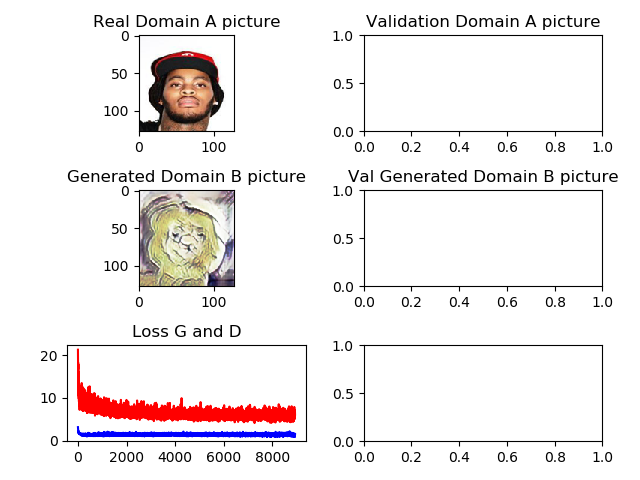

In [15]:
%matplotlib notebook
f, (real_pics, gen_pics, loss_axis) = plt.subplots(3, 2)
real_pics[0].set_title("Real Domain A picture")
gen_pics[0].set_title("Generated Domain B picture")
loss_axis[0].set_title("Loss G and D")
real_pics[1].set_title("Validation Domain A picture")
gen_pics[1].set_title("Val Generated Domain B picture")
#real_pic.plot()
#gen_pic.plot()
loss_d = []
loss_g = []
loss_axis[0].plot(loss_d, list(range(len(loss_d))), 'b',
               loss_g, list(range(len(loss_g))), 'r')
plt.tight_layout()

In [16]:
model = MUnit(in_channels=3, mlp_hidden_dim=256, mlp_num_blocks=3, d_num_scales=3,
              enc_style_dims=8, enc_cont_num_blocks=4, enc_cont_dim=256)
model.cuda();
model.train();
model.apply(init_weights);

In [17]:
def train_loop(num_epochs, train_dataloader, model):
    optimizer_G = optim.Adam(list(model.G1.parameters()) + list(model.G2.parameters()), lr=0.0002, betas=(0.5, 0.999))
    optimizer_D = optim.Adam(list(model.D1.parameters()) + list(model.D2.parameters()), lr=0.0002, betas=(0.5, 0.999))
    lr = 0.0001
    for epoch in range(num_epochs):

        if epoch % 50 == 49:
            save_cyclegan_model(model.G1, model.G2, model.D1, model.D2, '/home/dpakhom1/Cycle_gan_pytorch/', epoch + 1, "_MUnit")
            
        if epoch > 100:
            for param_group in optimizer_G.param_groups:
                param_group['lr'] = max(lr - 0.00002, 0)
            for param_group in optimizer_D.param_groups:
                param_group['lr'] = max(lr - 0.00002, 0)
                
        for idx, data in enumerate(train_dataloader):
            domain_A, domain_B = data["A"].cuda(), data["B"].cuda()
            
            #fake_B, cycle_BA, fake_A, cycle_AB = calc_Gs_outputs(G1, G2, domain_A, domain_B)
            cont_A, style_A, cont_B, style_B, fake_style_A, fake_A, fake_style_B, fake_B = model.forward(domain_A, domain_B)
            
            set_requires_grad([model.D1, model.D2], False)
            optimizer_G.zero_grad()
            loss_G = model.backward_Gs(domain_A, domain_B, cont_A, style_A, cont_B, style_B, fake_style_A, fake_A, fake_style_B, fake_B)
            loss_g.append(loss_G.item())
            
            optimizer_G.step()
            #if idx % 5 == 4:
            set_requires_grad([model.D1, model.D2], True)
            optimizer_D.zero_grad()
            
            
            
            #fake_A = img_bufferA.update(fake_A)
            #loss_D1 = backward_D(domain_A, fake_A, model.D1)
            #fake_B = img_bufferB.update(fake_B)
            #loss_D2 = backward_D(domain_B, fake_B, model.D2)
            loss_D = model.backward_Ds(domain_A, fake_A, domain_B, fake_B)
            loss_d.append(loss_D)
            optimizer_D.step()
            
            if idx % 200 == 199:
                print("Epoch: ", epoch + 1, "\n", "Gen loss: ", loss_G, "\n", "Discr loss: ", loss_D)

            if idx % 20 == 19:
                with torch.no_grad():
                    real_pics[0].imshow(tensor_to_image(torch.squeeze(data["A"])))
                    #real_pic.imshow(np.transpose(torch.squeeze(domain_A).cpu().detach().numpy(), (1, 2, 0)))
                    real_pics[0].relim()
                    real_pics[0].autoscale_view()
                    real_pics[0].figure.canvas.draw()
                    model.G1.eval()
                    model.G2.eval()
                    pic_cont, pic_style = model.G1.encode(domain_A)
                    random_style = torch.rand(*pic_style.shape).cuda()
                    output = model.G2.decode(pic_cont, random_style)
                    output = (((np.transpose(torch.squeeze(fake_B.detach().cpu()).numpy(), (1, 2, 0)) + 1)/2)*255).astype(np.uint8)
                    #output = transforms.ToPILImage()(torch.squeeze(fake_B.cpu())).convert("RGB")
                    gen_pics[0].imshow(output)
                    gen_pics[0].relim()
                    gen_pics[0].autoscale_view()
                    gen_pics[0].figure.canvas.draw()
                    model.G1.train()
                    model.G2.train()
                    
                    loss_axis[0].lines[0].set_xdata(list(range(len(loss_d))))
                    loss_axis[0].lines[0].set_ydata(loss_d)
                    loss_axis[0].lines[1].set_xdata(list(range(len(loss_g))))
                    loss_axis[0].lines[1].set_ydata(loss_g)
                    loss_axis[0].relim()
                    loss_axis[0].autoscale_view()
                    loss_axis[0].figure.canvas.draw()
#         for data in val_dataloader:
#             with torch.no_grad():
#                 domain_A = data["A"].cuda()
#                 real_pics[1].imshow(tensor_to_image(torch.squeeze(data["A"])))
#                 #real_pic.imshow(np.transpose(torch.squeeze(domain_A).cpu().detach().numpy(), (1, 2, 0)))
#                 real_pics[1].relim()
#                 real_pics[1].autoscale_view()
#                 real_pics[1].figure.canvas.draw()
#                 G1.eval()
#                 fake_B = G1(domain_A)
#                 output = (((np.transpose(torch.squeeze(fake_B.detach().cpu()).numpy(), (1, 2, 0)) + 1)/2)*255).astype(np.uint8)
#                 #output = transforms.ToPILImage()(torch.squeeze(fake_B.cpu())).convert("RGB")
#                 gen_pics[1].imshow(output)
#                 gen_pics[1].relim()
#                 gen_pics[1].autoscale_view()
#                 gen_pics[1].figure.canvas.draw()
#                 G1.train()
#             break

In [18]:
train_loop(10, train_dataloader, model)

/home/dpakhom1/anaconda3/lib/python3.7/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")
/home/dpakhom1/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:  1 
 Gen loss:  tensor(6.9239, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(1.3027, device='cuda:0', grad_fn=<ThAddBackward>)
Epoch:  1 
 Gen loss:  tensor(8.5527, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(1.3230, device='cuda:0', grad_fn=<ThAddBackward>)
Epoch:  1 
 Gen loss:  tensor(9.6254, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(1.2639, device='cuda:0', grad_fn=<ThAddBackward>)
Epoch:  1 
 Gen loss:  tensor(7.5028, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(1.3711, device='cuda:0', grad_fn=<ThAddBackward>)
Epoch:  1 
 Gen loss:  tensor(7.4477, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(1.3139, device='cuda:0', grad_fn=<ThAddBackward>)
Epoch:  1 
 Gen loss:  tensor(7.3804, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(1.2395, device='cuda:0', grad_fn=<ThAddBackward>)
Epoch:  1 
 Gen loss:  tensor(5.9895, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr 

Process Process-7:
Process Process-8:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/dpakhom1/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/dpakhom1/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/dpakhom1/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/dpakhom1/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/dpakhom1/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 96, in _worker_loop
    r = index_queue.get(timeout=MANAGER_STATUS_CHECK_INTERVAL)
  File "/home/dpakhom1/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 96, in _worker_loop
    r = index_queue.get(timeout=MANAGER_STATUS_CHECK_INTERVAL)
  File "/home/dpakhom1

KeyboardInterrupt: 